# Lab 8

In this lab, we build a convolutional neural netowrk for classification of CIFAR-10 images. 
For more information about CIFAR-10 and CIFAR-100 datasets visit: https://www.cs.toronto.edu/~kriz/cifar.html

The first step is to import the libraries.

In [201]:
### Import required libraries

import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
import tarfile
from torchvision.datasets import CIFAR10, MNIST
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.ndimage import shift, rotate
import random
### if you get trouble downloading the CIFAR-10 dataset from pytorch due to SSL issues, uncomment the following two lines
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context


Noe we set up the computing environment.

In [202]:
### Computing Environment Setup 
if torch.cuda.is_available():
    num_GPUs = torch.cuda.device_count()
    print(f'Available GPUs: {num_GPUs}')
    os.environ["CUDA_VISIBLE_DEVICES"] = 0 
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    torch.cuda.set_device(int(configs['gpu']))
else:
    print('GPU is not available.')
    device = torch.device("cpu")
    num_GPUs = 0
print(f'Device is {device}.')

### Fix random seeds for reproducibility
SEED = 12345
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)  

### Set number of workers for loading data
# Interesting read: https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/5
if num_GPUs == 0:
    num_workers = 8
else:
    num_workers = 4 * num_GPUs 



GPU is not available.
Device is cpu.


In [203]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Setting up the hyperparameters of our model.

In [204]:
### Parameters and Hyperparameters Setup
batch_size = 32 
valid_size = 0.1
num_epochs = 10
learning_rate = 0.001
momentum = 0.9
print_every_other = 2000 # print training loss every n batch
save_model = True # save the trained model
model_save_path = './mnist_net.pth' # path and file name to save the trained model


In [205]:
# transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))

train_transform = transforms.Compose(
    [transforms.ToTensor()
    ])
valid_transform = transforms.Compose(
    [transforms.ToTensor()
    ])


shifted_train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1))
    ])
shifted_valid_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1))
    ])

train_dataset = MNIST('./data', 
                       train=True, 
                       download=True, 
                       transform=train_transform)

validation_dataset = MNIST('./data', 
                        train=True, 
                        download = True,
                        transform=valid_transform)

test_dataset = MNIST('./data', 
                     train=False, 
                     download = True,
                     transform=valid_transform)


shifted_train_dataset = MNIST('./data', 
                        train=True, 
                        download = True,
                        transform=shifted_train_transform)

shifted_validation_dataset = MNIST('./data', 
                        train=True, 
                        download = True,
                        transform=shifted_valid_transform)

shifted_test_dataset = MNIST('./data', 
                     train=False, 
                     download = True,
                     transform=shifted_valid_transform)



num_train = len(train_dataset)
split = int(np.floor(valid_size * num_train))
indices = list(range(num_train))
np.random.shuffle(indices)


train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)




train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False, sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                          shuffle=False, sampler=valid_sampler, num_workers=num_workers)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

### Shifted Loader
shifted_train_loader = torch.utils.data.DataLoader(shifted_train_dataset, batch_size=batch_size,
                                          shuffle=False, sampler=train_sampler, num_workers=num_workers)

shifted_valid_loader = torch.utils.data.DataLoader(shifted_validation_dataset, batch_size=batch_size,
                                          shuffle=False, sampler=valid_sampler, num_workers=num_workers)


shifted_test_loader = torch.utils.data.DataLoader(shifted_test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


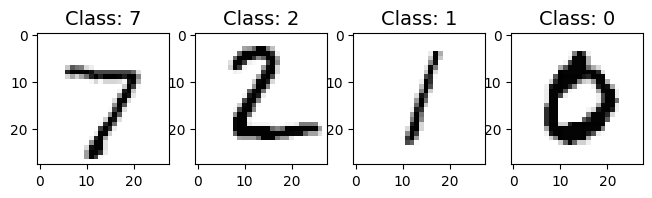

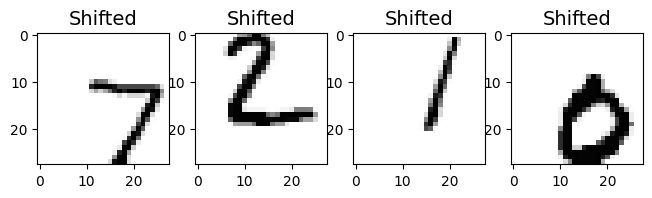

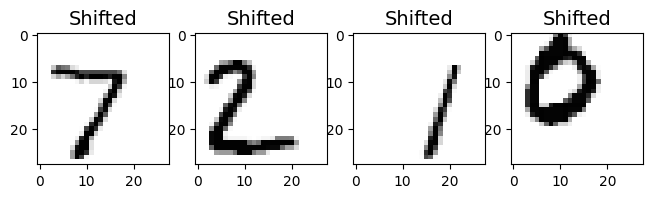

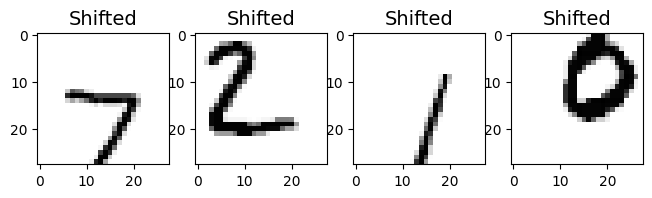

In [224]:
shift_delta = 5
dataset_to_visualize = test_loader
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image

## Select a batch of images
for (X_train, y_train) in dataset_to_visualize:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
    
plt.figure(figsize=(18,120))
for i in range(4):
    plt.subplot(1,9,i+1)
    plt.title('Class: '+str(y_train[i].item()), fontsize=14)
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.show()


for j in range(3):
    plt.figure(figsize=(18,120))
    for i in range(4):
        plt.subplot(1,9,i+1)
        # plt.title('Shifted Class: '+str(y_train[i].item()), fontsize=14)
        plt.title('Shifted', fontsize=14)    
        # plt.axis('off')
        plt.imshow(shift_image(X_train[i,:,:,:].numpy(),random.randint(-shift_delta, shift_delta),random.randint(-shift_delta, shift_delta)), interpolation="nearest", cmap="Greys")

plt.show()



Loading the dataset using torchvision.

In [207]:
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = MLP_Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)
print(count_parameters(model))


MLP_Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
42310


In [208]:
def train(epoch, log_interval=2000):
    correct = 0
    total = 0
    acc_collect = []
    loss_collect = []
    # Set model to training mode
    model.train()
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        acc = correct / total
        acc_collect.append(acc)
        loss_collect.append(loss.data.item())
        
        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            correct = 0
            total = 0
            print('Train Epoch: {}, BatchIndx: {}, Loss: {:.6f}, Accuracy: {:.4f} '.format(
                epoch, batch_idx, loss.data.item(), acc))
    return np.mean(acc_collect), np.mean(loss_collect)

In [209]:
def model_validation(net, valid_loader, criterion, test_flag=False):
    correct = 0
    total = 0
    counter = 0
    total_loss = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, labels).item()
            total_loss += loss
            counter+=1
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = correct / total
        loss = total_loss/counter
        if test_flag==False:
            print('\nValidation set: Average loss: {:.4f}, Accuracy: {:.4f}\n'.format(loss, acc))
        elif test_flag:
            print('\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n'.format(loss, acc))
    return acc, loss

In [210]:
%%time

valid_loss_collect = []
valid_acc_collect = []
train_loss_collect = []
train_acc_collect = []
for epoch in range(1, num_epochs + 1):
    train_acc, train_loss = train(epoch)
    valid_acc, valid_loss = model_validation(model,valid_loader, criterion)
    valid_loss_collect.append(valid_loss) 
    valid_acc_collect.append(valid_acc) 
    train_acc_collect.append(train_acc) 
    train_loss_collect.append(train_loss) 

mlpvalid_loss_collect = valid_loss_collect
mlpvalid_acc_collect = valid_acc_collect
mlptrain_loss_collect = train_loss_collect
mlptrain_acc_collect = train_acc_collect

Train Epoch: 1, BatchIndx: 0, Loss: 2.314097, Accuracy: 0.0312 

Validation set: Average loss: 0.5674, Accuracy: 0.8218

Train Epoch: 2, BatchIndx: 0, Loss: 0.577403, Accuracy: 0.8125 

Validation set: Average loss: 0.4177, Accuracy: 0.8805

Train Epoch: 3, BatchIndx: 0, Loss: 0.263466, Accuracy: 0.9375 

Validation set: Average loss: 0.3446, Accuracy: 0.9002

Train Epoch: 4, BatchIndx: 0, Loss: 0.305268, Accuracy: 0.8750 

Validation set: Average loss: 0.2955, Accuracy: 0.9145

Train Epoch: 5, BatchIndx: 0, Loss: 0.118688, Accuracy: 0.9688 

Validation set: Average loss: 0.2912, Accuracy: 0.9183

Train Epoch: 6, BatchIndx: 0, Loss: 0.360795, Accuracy: 0.9688 

Validation set: Average loss: 0.2570, Accuracy: 0.9270

Train Epoch: 7, BatchIndx: 0, Loss: 0.469807, Accuracy: 0.9062 

Validation set: Average loss: 0.2429, Accuracy: 0.9297

Train Epoch: 8, BatchIndx: 0, Loss: 0.378759, Accuracy: 0.8438 

Validation set: Average loss: 0.2365, Accuracy: 0.9357

Train Epoch: 9, BatchIndx: 0, Lo

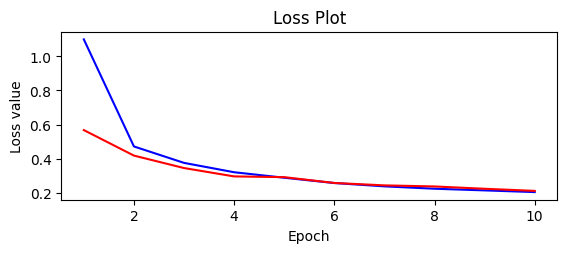

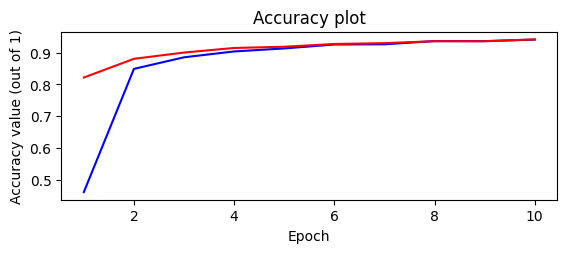

In [211]:


plt.subplot(2, 1, 1)
t = range(1,len(valid_acc_collect)+1)
plt.plot(t, train_loss_collect, 'b', label="Training")
plt.plot(t, valid_loss_collect, 'r', label="Validation") 
plt.title('Loss Plot')
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

plt.subplot(2, 1, 2)
plt.plot(t, train_acc_collect, 'b', label="Training")
plt.plot(t, valid_acc_collect, 'r', label="Validation") 
plt.title('Accuracy plot')
plt.xlabel("Epoch")
plt.ylabel("Accuracy value (out of 1)")
plt.show()



In [212]:
test_acc, test_loss = model_validation(model,test_loader, criterion, test_flag=True)
test_acc, test_loss = model_validation(model,shifted_test_loader, criterion, test_flag=True)


Test set: Average loss: 0.2058, Accuracy: 0.9410


Test set: Average loss: 1.5703, Accuracy: 0.6308



In [213]:

class CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(256, 32)
        # self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNN_Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model)
print(count_parameters(model))

CNN_Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
15386


In [214]:
%%time

valid_loss_collect = []
valid_acc_collect = []
train_loss_collect = []
train_acc_collect = []
for epoch in range(1, num_epochs + 1):
    train_acc, train_loss = train(epoch)
    valid_acc, valid_loss = model_validation(model,valid_loader, criterion)
    valid_loss_collect.append(valid_loss) 
    valid_acc_collect.append(valid_acc) 
    train_acc_collect.append(train_acc) 
    train_loss_collect.append(train_loss) 


cnnvalid_loss_collect = valid_loss_collect
cnnvalid_acc_collect = valid_acc_collect
cnntrain_loss_collect = train_loss_collect
cnntrain_acc_collect = train_acc_collect


Train Epoch: 1, BatchIndx: 0, Loss: 2.306358, Accuracy: 0.0938 

Validation set: Average loss: 0.1972, Accuracy: 0.9378

Train Epoch: 2, BatchIndx: 0, Loss: 0.181950, Accuracy: 0.9062 

Validation set: Average loss: 0.1109, Accuracy: 0.9657

Train Epoch: 3, BatchIndx: 0, Loss: 0.041241, Accuracy: 1.0000 

Validation set: Average loss: 0.0775, Accuracy: 0.9765

Train Epoch: 4, BatchIndx: 0, Loss: 0.029365, Accuracy: 1.0000 

Validation set: Average loss: 0.0711, Accuracy: 0.9782

Train Epoch: 5, BatchIndx: 0, Loss: 0.002733, Accuracy: 1.0000 

Validation set: Average loss: 0.0631, Accuracy: 0.9805

Train Epoch: 6, BatchIndx: 0, Loss: 0.155609, Accuracy: 0.9375 

Validation set: Average loss: 0.0631, Accuracy: 0.9822

Train Epoch: 7, BatchIndx: 0, Loss: 0.026604, Accuracy: 1.0000 

Validation set: Average loss: 0.0515, Accuracy: 0.9847

Train Epoch: 8, BatchIndx: 0, Loss: 0.002825, Accuracy: 1.0000 

Validation set: Average loss: 0.0658, Accuracy: 0.9817

Train Epoch: 9, BatchIndx: 0, Lo

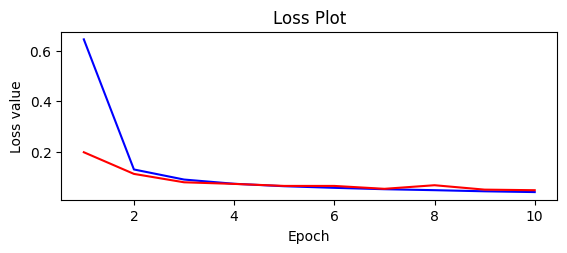

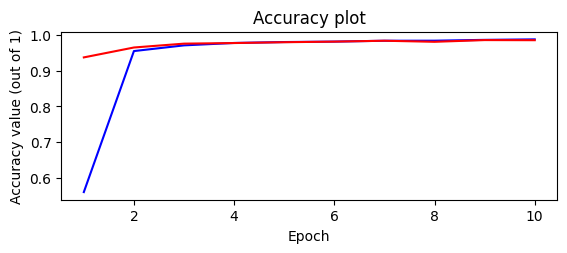

In [215]:

plt.subplot(2, 1, 1)
t = range(1,len(valid_acc_collect)+1)
plt.plot(t, train_loss_collect, 'b', label="Training")
plt.plot(t, valid_loss_collect, 'r', label="Validation") 
plt.title('Loss Plot')
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

plt.subplot(2, 1, 2)
plt.plot(t, train_acc_collect, 'b', label="Training")
plt.plot(t, valid_acc_collect, 'r', label="Validation") 
plt.title('Accuracy plot')
plt.xlabel("Epoch")
plt.ylabel("Accuracy value (out of 1)")
plt.show()

In [216]:
test_acc, test_loss = model_validation(model,test_loader, criterion, test_flag=True)
test_acc, test_loss = model_validation(model,shifted_test_loader, criterion, test_flag=True)


Test set: Average loss: 0.0374, Accuracy: 0.9867


Test set: Average loss: 0.5170, Accuracy: 0.8650



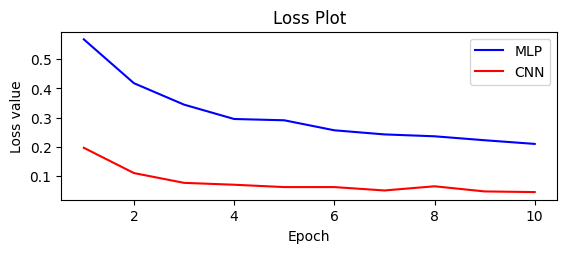

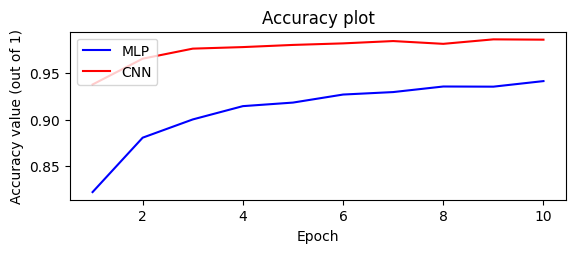

In [220]:

plt.subplot(2, 1, 1)
t = range(1,len(valid_acc_collect)+1)
plt.plot(t, mlpvalid_loss_collect, 'b',label='MLP')
plt.plot(t, cnnvalid_loss_collect, 'r',label='CNN') 
plt.title('Loss Plot')
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend(loc="upper right")
plt.show()

plt.subplot(2, 1, 2)
plt.plot(t, mlpvalid_acc_collect, 'b',label='MLP')
plt.plot(t, cnnvalid_acc_collect, 'r',label='CNN') 
plt.title('Accuracy plot')
plt.xlabel("Epoch")
plt.ylabel("Accuracy value (out of 1)")
plt.legend(loc="upper left")
plt.show()

## CIFAR-10

In [4]:
### Loading the data

train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Interesting read: https://stackoverflow.com/questions/65676151/how-does-torchvision-transforms-normalize-operate
    ])

valid_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=valid_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_transform)

num_train = len(trainset)
split = int(np.floor(valid_size * num_train))
indices = list(range(num_train))
np.random.shuffle(indices)


train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)




trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, sampler=train_sampler, num_workers=num_workers)

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, sampler=valid_sampler, num_workers=num_workers)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

print(len(trainloader.sampler), len(validloader.sampler))

target_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
45000 5000


Let's see some samples from the training dataset.

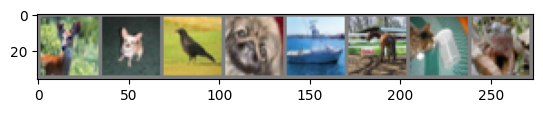

deer  dog   bird  dog   ship  horse cat   frog 


In [5]:
### Visualization of images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Select a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## Show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{target_names[labels[j]]:5s}' for j in range(batch_size))) 

It iss time to build our network.

In [40]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


Need to set up the loss function and optimizer.

In [11]:
### Setting up the training environment
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [12]:
def model_validation(net, validloader, criterion):
    correct = 0
    total = 0
    counter = 0
    total_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in validloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            loss = criterion(outputs, labels).item()
            total_loss += loss
            counter+=1
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = correct / total
        loss = total_loss/counter
    return loss, acc 


In [ ]:
### Training 
print('Training ...')
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    running_acc = 0
    count_samples = 0
    
    for iter, data in enumerate(trainloader, 0):
        inputs, labels = data # data is a list of [inputs, labels]
        ## Copying the data to device
        inputs = inputs.to(device) 
        labels = labels.to(device)
        ## Zero-ing the grads
        optimizer.zero_grad()

        ## Feed forward
        outputs = net(inputs)
        ## Compupting loss
        loss = criterion(outputs, labels)
        ## Compute the gradients
        loss.backward()
        ## Perform a single optimization step
        optimizer.step()



        # Collect and print training statistics
        running_loss += loss.item()
        if iter % print_every_other == print_every_other-1:    # print every 2000 mini-batches
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()   
            count_samples = len(labels)
            print(f' Epoch: {epoch + 1}, Iteration: {iter + 1:5d}, Train Loss: {running_loss / print_every_other:.3f}, Train Accuracy: {correct / count_samples}')
            running_loss = 0.0


    valid_loss, valid_acc = model_validation(net, validloader, criterion)
    print(f' Epoch: {epoch + 1}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}')


print('Finished Training')

In [ ]:
### Save the trained model
if save_model:
    torch.save(net.state_dict(), model_save_path)

In [11]:
if os.path.isfile(model_save_path):
    net = Net()
    net.load_state_dict(torch.load(model_save_path))
    print('Loaded saved model.')
else:
    print('Saved model does not exist!')

Loaded saved model.


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print(total,correct)

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 9.87 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in target_names}
total_pred = {classname: 0 for classname in target_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[target_names[label]] += 1
            total_pred[target_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## Questions

In this lab, we Use the convolutional neural network dicsussed in Lab 5 to address the following questions.

1. Implement k-fold cross-validation with k=5 and report the results including average and standard deviaion of accuracy, f1-score, sensitivity, specificity as $\%xx.x\pm xx.x$ e.g. $\% 65.1\pm 2.1$

2. Plot the training and validation loss and accuracy curves (for each epoch) in a single figure and discuss your observation with respect to the training performance. Do you observe under-fitting and/or over-fitting? If so, define in wich epochs. 

3. Implament two regularization methods to prevent over-fitting in training the model. Describe how these approaches can reduce over-fitting.
Report the results according to 1.

4. Propose, describe, and implement two approaches (not including regularization) to enhance the classificaton performance fo the model. Report the results according to 1.